### The note book where I will develop the code to collate port information and produce fits

In [1]:
# import stuff
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers

import core.functions as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

### collect data from files and load

In [2]:
def collate_ports(path_array):
    '''
    Collect individual ports and merge the information

    Args:
        path_array          :           an array of folder paths to h5 files
                                        respective of the multiple ports

    
    Returns:
        array               :           output of collective ports
    '''

    # strip array except from port information
    port_id = [x.split('PORT_')[1][:2] for x in path_array]

    for i in range(len(path_array)):
        print("Porting {}".format(path_array[i]))
        if (i==0):
            tracks = (func.load_data(path_array[i]))[0]
            # add on the column for port ID
            tracks['PORT'] = str(port_id[i])
        else:
            nu_tracks = (func.load_data(path_array[i]))[0]
            print("Tracks: {}".format(func.len_events(nu_tracks)))
            # multiply the events numbers to avoid overlap
            nu_tracks['event'] = nu_tracks['event'] * (i+1)
            nu_tracks['PORT'] = str(port_id[i])
            tracks = tracks.append(nu_tracks)

        print("Done! Tracks available: {}".format(func.len_events(tracks)))
    
    return tracks

def positron_ports(path_array):
    '''
    Collect positron events from multiple ports.
    Bespoke, use with care.
    '''

    for i in range(len(path_array)):
        print("Loading positrons from {}".format(path_array[i]))
        if (i==0):
            posi = func.positron_scraper(path_array[i])
            # multiply the event numbers to match track values
            posi['event_id'] = posi['event_id'] * ((i+1)*2)
        else:
            nu_posi = func.positron_scraper(path_array[i])
            print("Positron events: {}".format(func.len_events(nu_posi, tag = 'event_id')))
            # multiple the event numbers to avoid overlap, the *2 is to match it with the tracking values
            nu_posi['event_id'] = nu_posi['event_id'] * ((i+1)*2)
            posi = posi.append(nu_posi)
        print("Port finished! Tracks available: {}".format(func.len_events(posi, tag = 'event_id')))
    
    return posi


In [3]:
folder_paths = ['75_9e-3/PORT_1a/isaura/', '75_9e-3/PORT_1b/isaura/', '75_9e-3/PORT_2a/isaura/']
full_tracks = collate_ports(folder_paths)

Porting 75_9e-3/PORT_1a/isaura/
50
100
150
200
250
300
Done! Tracks available: 87009
Porting 75_9e-3/PORT_1b/isaura/
50
100
150
200
250
300
Tracks: 84703
Done! Tracks available: 152826
Porting 75_9e-3/PORT_2a/isaura/
50
100
150
200
250
300
Tracks: 60529
Done! Tracks available: 198973


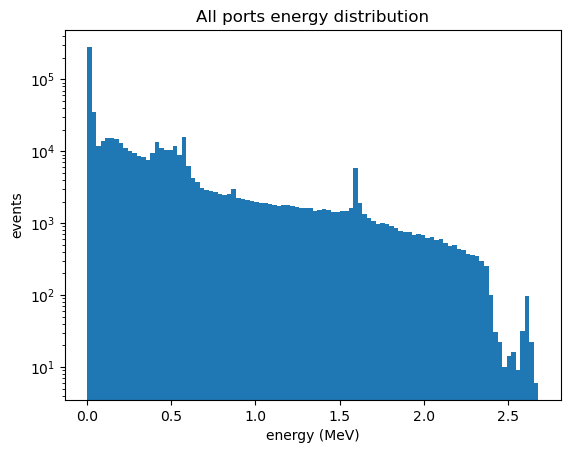

In [4]:
func.plot_hist(full_tracks, binning = 100, title='All ports energy distribution')

In [5]:
display(full_tracks)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,PORT
0,5080000,0,1.068732,168.887195,64,9158,1,375.675,161.675,330.900281,...,384.212773,278.679478,445.580642,0.498749,0.045366,0.000000,12.200000,14.000000,13.534216,1a
1,5080002,0,1.282228,248.187363,42,4241,4,-79.325,344.675,515.180105,...,94.850390,364.689594,517.833734,0.367780,0.074493,0.000000,14.444444,14.125000,14.263647,1a
2,5080002,1,0.654868,69.761558,18,2150,4,-100.325,415.675,603.385913,...,-89.159408,425.914687,608.759268,0.384472,0.085811,0.000000,14.444444,14.125000,14.263647,1a
3,5080002,2,0.147971,14.444444,2,457,4,133.675,360.675,499.470366,...,151.087271,367.376060,502.128486,0.147971,0.147971,0.147971,14.444444,14.125000,14.263647,1a
4,5080002,3,0.023711,14.125000,2,79,4,30.675,411.675,618.959316,...,34.008329,416.683574,620.686133,0.023711,0.023711,0.023711,14.444444,14.125000,14.263647,1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137095,12181404,5,0.000006,0.000000,1,1,6,98.675,-393.325,403.428736,...,98.675000,-393.325000,403.428736,0.000006,0.000006,0.000006,14.857143,14.881356,13.668509,2a
137096,12181410,0,0.289894,20.714286,4,3299,4,-67.325,-396.325,918.424894,...,-57.257299,-387.239439,923.537166,0.275602,0.274273,0.260051,15.000000,14.285714,14.723900,2a
137097,12181410,1,0.226644,25.414068,7,3046,4,23.675,-282.325,694.861978,...,40.922239,-261.211636,710.203661,0.217054,0.211340,0.201749,15.000000,14.285714,14.723900,2a
137098,12181410,2,0.000498,14.285714,2,32,4,0.675,-383.325,921.421791,...,3.214060,-380.493759,921.421791,0.000498,0.000498,0.000498,15.000000,14.285714,14.723900,2a


In [6]:
# satellite merge
low_e_tracks = func.remove_low_E_events(full_tracks)

cut_tracks = func.apply_cuts(low_e_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)

/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)


Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 40.72 %
Absolute Cut efficiency:
Efficiency: 40.72 %
One track cut
Relative Cut efficiency:
Efficiency: 64.68 %
Absolute Cut efficiency:
Efficiency: 53.25 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 72.55 %
Absolute Cut efficiency:
Efficiency: 71.49 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.78 %
Absolute Cut efficiency:
Efficiency: 7.61 %


In [7]:
# save the data here
cut_tracks[0].to_csv('cut_tracks.csv')


In [8]:
display(cut_tracks[0])
cut_tracks_test = pd.read_csv('cut_tracks.csv')
display(cut_tracks_test)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,PORT
107,5080086,0,1.683154,324.712905,75,7056,1,-240.325,-178.325,1037.969888,...,-217.390057,-41.463176,1044.619150,0.425738,0.077629,0.0,14.875000,14.500000,13.632267,1a
737,5080582,0,1.597251,142.007874,59,6551,1,296.675,-46.325,681.238031,...,337.279082,56.812115,714.750819,0.391053,0.238712,0.0,14.142857,14.500000,13.223831,1a
854,5080676,0,1.594962,141.841206,50,7768,1,179.675,146.675,453.319420,...,273.088557,157.066900,509.242530,0.625310,0.377647,0.0,14.428571,14.666667,13.097077,1a
984,1740022,0,1.595983,240.220791,71,7411,1,187.675,-35.325,409.113469,...,196.685108,54.418912,425.195124,0.514368,0.456328,0.0,13.800000,14.571429,13.871316,1a
1054,1740082,0,1.619501,331.972634,74,7845,1,-10.325,-338.325,191.247312,...,85.790312,-134.035423,305.482562,0.441276,0.031332,0.0,14.714286,14.133333,13.536416,1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658487,14821002,0,1.597759,152.704345,55,6507,1,-250.325,-64.325,1033.027275,...,-228.022302,55.031051,1085.076712,0.305187,0.132411,0.0,13.500000,14.111111,13.538000,2a
658675,12180240,0,1.593503,168.933124,59,7329,1,247.675,13.675,810.576047,...,287.754545,23.109780,818.112728,0.430172,0.261936,0.0,14.714286,15.000000,13.402069,2a
658853,12180756,0,1.597874,84.486164,43,8744,1,49.675,-137.325,322.404338,...,95.135160,-112.447335,327.540984,0.254408,0.105188,0.0,13.500000,13.800000,13.682209,2a
658904,12180888,0,1.596929,178.966898,57,6689,1,169.675,129.675,1087.524900,...,292.144829,210.538713,1121.916075,0.362043,0.032287,0.0,14.222222,14.333333,13.040278,2a


,Unnamed: 0,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,PORT
0,107,5080086,0,1.683154,324.712905,75,7056,1,-240.325,-178.325,...,-217.390057,-41.463176,1044.619150,0.425738,0.077629,0.0,14.875000,14.500000,13.632267,1a
1,737,5080582,0,1.597251,142.007874,59,6551,1,296.675,-46.325,...,337.279082,56.812115,714.750819,0.391053,0.238712,0.0,14.142857,14.500000,13.223831,1a
2,854,5080676,0,1.594962,141.841206,50,7768,1,179.675,146.675,...,273.088557,157.066900,509.242530,0.625310,0.377647,0.0,14.428571,14.666667,13.097077,1a
3,984,1740022,0,1.595983,240.220791,71,7411,1,187.675,-35.325,...,196.685108,54.418912,425.195124,0.514368,0.456328,0.0,13.800000,14.571429,13.871316,1a
4,1054,1740082,0,1.619501,331.972634,74,7845,1,-10.325,-338.325,...,85.790312,-134.035423,305.482562,0.441276,0.031332,0.0,14.714286,14.133333,13.536416,1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4093,658487,14821002,0,1.597759,152.704345,55,6507,1,-250.325,-64.325,...,-228.022302,55.031051,1085.076712,0.305187,0.132411,0.0,13.500000,14.111111,13.538000,2a
4094,658675,12180240,0,1.593503,168.933124,59,7329,1,247.675,13.675,...,287.754545,23.109780,818.112728,0.430172,0.261936,0.0,14.714286,15.000000,13.402069,2a
4095,658853,12180756,0,1.597874,84.486164,43,8744,1,49.675,-137.325,...,95.135160,-112.447335,327.540984,0.254408,0.105188,0.0,13.500000,13.800000,13.682209,2a
4096,658904,12180888,0,1.596929,178.966898,57,6689,1,169.675,129.675,...,292.144829,210.538713,1121.916075,0.362043,0.032287,0.0,14.222222,14.333333,13.040278,2a


4098


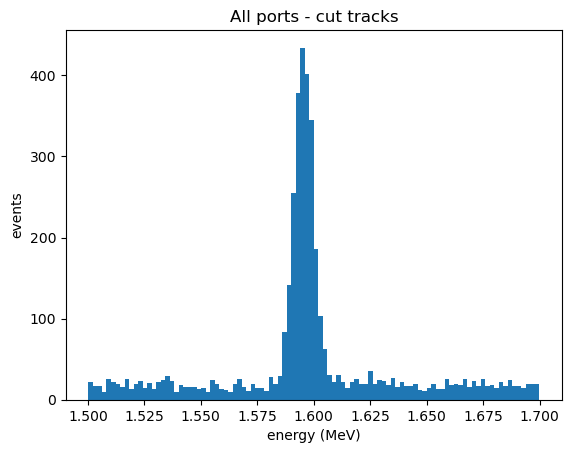

In [9]:
func.plot_hist(cut_tracks[0], binning = 100, title='All ports - cut tracks', log = False)
print(func.len_events(cut_tracks[0]))

In [10]:
eblob_tracks = cut_tracks[0][(cut_tracks[0]['eblob2'] > 0.2)]

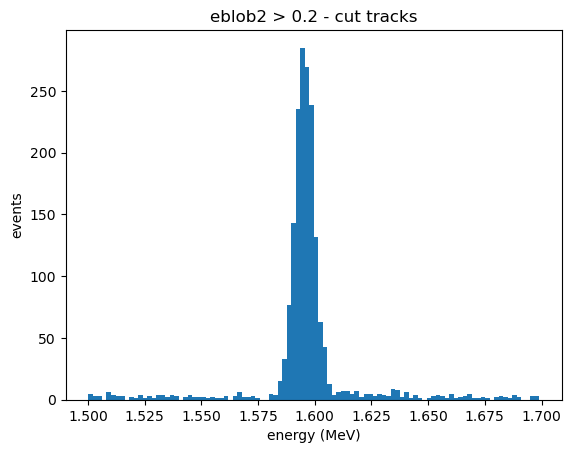

In [11]:
func.plot_hist(eblob_tracks, binning = 100, title='eblob2 > 0.2 - cut tracks', log = False)

### But now, lets create this with only positron events. How annoying!

In [12]:
# find positron events per port
pos_events = positron_ports(folder_paths)

Loading positrons from 75_9e-3/PORT_1a/isaura/
Port finished! Tracks available: 13282
Loading positrons from 75_9e-3/PORT_1b/isaura/
Positron events: 12865
Port finished! Tracks available: 25717
Loading positrons from 75_9e-3/PORT_2a/isaura/
Positron events: 9663
Port finished! Tracks available: 34976


In [13]:
pos_events.to_csv('positron_events.csv')

In [14]:
positron_events = pd.read_csv('positron_events.csv')
display(positron_events)

,Unnamed: 0,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,302,5080008,42,e+,False,40,399.615420,394.366060,536.81540,0.004905,...,0.780250,0.557767,1.590467,-0.0,-0.0,0.0,1.415293,1.324204,conv,annihil
1,1182,5080032,32,e+,False,30,-166.862320,-370.026580,1148.35820,3.770954,...,-0.247377,-0.461457,1.173200,0.0,0.0,-0.0,0.871628,187.018860,conv,annihil
2,1375,5080036,37,e+,False,35,-65.955795,324.198030,272.43747,1.781441,...,-1.258215,-0.110806,-0.581811,0.0,-0.0,0.0,0.970557,263.940030,conv,annihil
3,1757,5080048,18,e+,False,16,394.422900,407.527100,535.74084,0.035130,...,0.217861,0.929769,-0.199142,0.0,-0.0,0.0,0.590233,0.248721,conv,annihil
4,1829,5080050,43,e+,False,41,466.010070,219.144070,487.87430,0.656721,...,0.595691,-1.389832,-0.308319,0.0,0.0,0.0,1.114628,0.823724,conv,annihil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35810,571950,12181188,55,e+,False,53,-317.644170,122.913124,780.97327,2.805562,...,-1.560910,-0.481398,-0.572206,0.0,0.0,0.0,1.293640,398.153530,conv,annihil
35811,572070,12181194,29,e+,False,27,388.389000,145.365880,1089.23900,0.848894,...,-0.078389,-0.186970,0.119934,-0.0,-0.0,-0.0,0.051679,3.023956,conv,annihil
35812,573711,12181302,91,e+,False,87,210.304980,-88.572310,528.88230,2.638315,...,0.204529,-0.242675,-0.472967,0.0,0.0,0.0,0.254208,50.648550,conv,annihil
35813,574540,12181368,34,e+,False,32,366.878700,391.280900,1094.12050,0.133110,...,-0.834090,-0.260838,-0.929550,0.0,-0.0,-0.0,0.863383,4.327487,conv,annihil


### collect positron events from our track data

In [15]:
# double checking event numbers
display(pos_events)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
302,5080008,42,e+,False,40,399.615417,394.366058,536.815430,0.004905,399.746094,...,0.780250,0.557767,1.590467,-0.0,-0.0,0.0,1.415293,1.324204,conv,annihil
1182,5080032,32,e+,False,30,-166.862320,-370.026581,1148.358154,3.770954,-198.535721,...,-0.247377,-0.461457,1.173200,0.0,0.0,-0.0,0.871628,187.018860,conv,annihil
1375,5080036,37,e+,False,35,-65.955795,324.198029,272.437469,1.781441,-22.099428,...,-1.258216,-0.110806,-0.581811,0.0,-0.0,0.0,0.970557,263.940033,conv,annihil
1757,5080048,18,e+,False,16,394.422913,407.527100,535.740845,0.035130,394.485077,...,0.217861,0.929769,-0.199142,0.0,-0.0,0.0,0.590233,0.248721,conv,annihil
1829,5080050,43,e+,False,41,466.010071,219.144073,487.874298,0.656721,466.172241,...,0.595691,-1.389832,-0.308319,0.0,0.0,0.0,1.114628,0.823723,conv,annihil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571950,12181188,55,e+,False,53,-317.644165,122.913124,780.973267,2.805562,-227.563492,...,-1.560910,-0.481398,-0.572206,0.0,0.0,0.0,1.293640,398.153534,conv,annihil
572070,12181194,29,e+,False,27,388.389008,145.365875,1089.239014,0.848894,388.548676,...,-0.078389,-0.186970,0.119934,-0.0,-0.0,-0.0,0.051679,3.023956,conv,annihil
573711,12181302,91,e+,False,87,210.304977,-88.572311,528.882324,2.638315,209.844193,...,0.204529,-0.242675,-0.472967,0.0,0.0,0.0,0.254208,50.648548,conv,annihil
574540,12181368,34,e+,False,32,366.878693,391.280914,1094.120483,0.133110,365.349640,...,-0.834090,-0.260838,-0.929550,0.0,-0.0,-0.0,0.863383,4.327487,conv,annihil


In [16]:
display(cut_tracks[0])

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,PORT
107,5080086,0,1.683154,324.712905,75,7056,1,-240.325,-178.325,1037.969888,...,-217.390057,-41.463176,1044.619150,0.425738,0.077629,0.0,14.875000,14.500000,13.632267,1a
737,5080582,0,1.597251,142.007874,59,6551,1,296.675,-46.325,681.238031,...,337.279082,56.812115,714.750819,0.391053,0.238712,0.0,14.142857,14.500000,13.223831,1a
854,5080676,0,1.594962,141.841206,50,7768,1,179.675,146.675,453.319420,...,273.088557,157.066900,509.242530,0.625310,0.377647,0.0,14.428571,14.666667,13.097077,1a
984,1740022,0,1.595983,240.220791,71,7411,1,187.675,-35.325,409.113469,...,196.685108,54.418912,425.195124,0.514368,0.456328,0.0,13.800000,14.571429,13.871316,1a
1054,1740082,0,1.619501,331.972634,74,7845,1,-10.325,-338.325,191.247312,...,85.790312,-134.035423,305.482562,0.441276,0.031332,0.0,14.714286,14.133333,13.536416,1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658487,14821002,0,1.597759,152.704345,55,6507,1,-250.325,-64.325,1033.027275,...,-228.022302,55.031051,1085.076712,0.305187,0.132411,0.0,13.500000,14.111111,13.538000,2a
658675,12180240,0,1.593503,168.933124,59,7329,1,247.675,13.675,810.576047,...,287.754545,23.109780,818.112728,0.430172,0.261936,0.0,14.714286,15.000000,13.402069,2a
658853,12180756,0,1.597874,84.486164,43,8744,1,49.675,-137.325,322.404338,...,95.135160,-112.447335,327.540984,0.254408,0.105188,0.0,13.500000,13.800000,13.682209,2a
658904,12180888,0,1.596929,178.966898,57,6689,1,169.675,129.675,1087.524900,...,292.144829,210.538713,1121.916075,0.362043,0.032287,0.0,14.222222,14.333333,13.040278,2a


In [17]:
# select only events in which events have positrons
sig_data = cut_tracks[0][cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]
bck_data = cut_tracks[0][~cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]

In [18]:
display(sig_data)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,PORT
737,5080582,0,1.597251,142.007874,59,6551,1,296.675,-46.325,681.238031,...,337.279082,56.812115,714.750819,0.391053,0.238712,0.0,14.142857,14.500000,13.223831,1a
854,5080676,0,1.594962,141.841206,50,7768,1,179.675,146.675,453.319420,...,273.088557,157.066900,509.242530,0.625310,0.377647,0.0,14.428571,14.666667,13.097077,1a
984,1740022,0,1.595983,240.220791,71,7411,1,187.675,-35.325,409.113469,...,196.685108,54.418912,425.195124,0.514368,0.456328,0.0,13.800000,14.571429,13.871316,1a
1300,1740272,0,1.585759,96.603199,52,7973,1,-188.325,53.675,411.501398,...,-118.512245,62.872010,445.278366,0.451501,0.414708,0.0,13.166667,12.833333,13.914674,1a
1637,1740538,0,1.601273,193.444398,49,7205,1,-103.325,-249.325,453.332480,...,-91.482329,-242.297144,508.823884,0.589608,0.299892,0.0,14.090909,14.000000,13.106973,1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658476,14820972,0,1.599220,234.859839,58,6300,1,141.675,-246.325,841.829888,...,147.839494,-233.666790,870.039122,0.537754,0.368148,0.0,14.714286,14.222222,14.370326,2a
658487,14821002,0,1.597759,152.704345,55,6507,1,-250.325,-64.325,1033.027275,...,-228.022302,55.031051,1085.076712,0.305187,0.132411,0.0,13.500000,14.111111,13.538000,2a
658675,12180240,0,1.593503,168.933124,59,7329,1,247.675,13.675,810.576047,...,287.754545,23.109780,818.112728,0.430172,0.261936,0.0,14.714286,15.000000,13.402069,2a
658853,12180756,0,1.597874,84.486164,43,8744,1,49.675,-137.325,322.404338,...,95.135160,-112.447335,327.540984,0.254408,0.105188,0.0,13.500000,13.800000,13.682209,2a


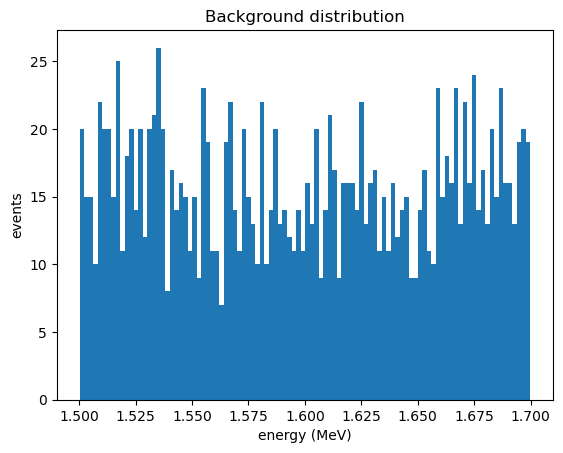

In [19]:
func.plot_hist(bck_data, binning = 100, title='Background distribution', log = False)

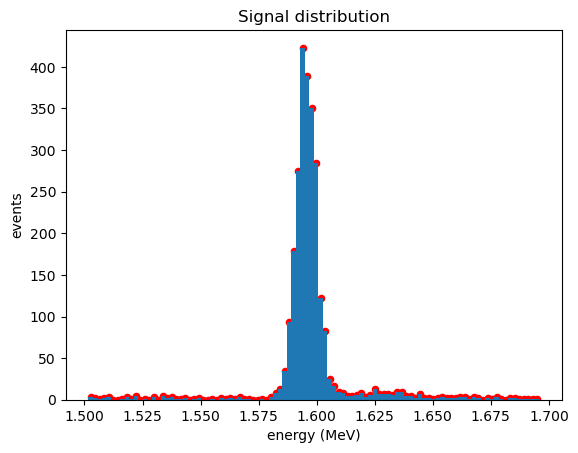

In [20]:
hist, edges, patches = func.plot_hist(sig_data, binning = 100, title='Signal distribution', log = False, data = True)

centres = shift_to_bin_centers(edges)
plt.scatter(centres, hist, color='red', s = 20)
plt.show()

In [21]:
# fit the signal function to our data here
#def sig_func(x, ns, a, mu, sigma, C1, C2):
#    # move this to functions.py (its already there, just for importing purposes this is easier)    
#    return ns * (skewnorm_func(x, a, mu, sigma) + C1*error_func(x, mu, sigma) + C2)
def print_parameters(popt,pcov,labels):
    '''
    Prints fitting parameters

    :param popt:        Fit parameters
    :param pcov:        Fit covariances
    :param labels:      Labels of parameters
    '''
    print('===============================')
    print("        Fitting output      ")
    print('===============================')
    for i in range(len(popt)):
        print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors
    print('===============================')
    return 0


# p0 is apriori
p0 = ([1, 5, 1.58, 0.3, 4.5, 2])
fit_labels = ['B1', 'A', 'mu', 'sigma', 'C1', 'C2']


popt, pcov = curve_fit(func.sig_func, centres, hist, p0, maxfev = 500000)

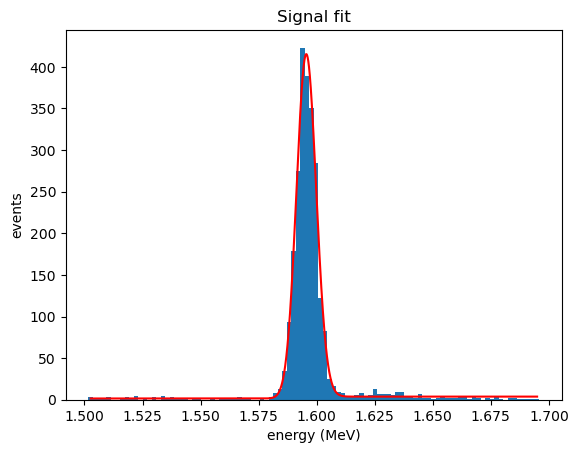

        Fitting output      
B1: 4.3838 ± 0.0491
A: 0.6210 ± 0.3270
mu: 1.5936 ± 0.0009
sigma: 0.0047 ± 0.0004
C1: -0.2576 ± 0.1706
C2: 0.8532 ± 0.2390


0

In [22]:
func.plot_fit(func.sig_func, centres, popt, fit_labels, popt_text=True)
func.plot_hist(sig_data, binning = 100, title='Signal fit', log = False)
plt.show()
print_parameters(popt, pcov, fit_labels)

In [23]:
# try the fit with the values set to C1 = 4.89e-4 and C2 = 1.99e-4
# p0 is apriori
def sig_func_fixed(x, ns, a, mu, sigma, C1 = 0, C2 = 0.8532):
    
    return ns * (func.skewnorm_func(x, a, mu, sigma) + C1*func.error_func(x, mu, sigma) + C2)



p0_fixed = ([1, 0.62, 1.58, 0.3])
fit_labels_fixed = ['B1', 'A', 'mu', 'sigma']


popt_f, pcov_f = curve_fit(sig_func_fixed, centres, hist, p0_fixed, maxfev = 500000)

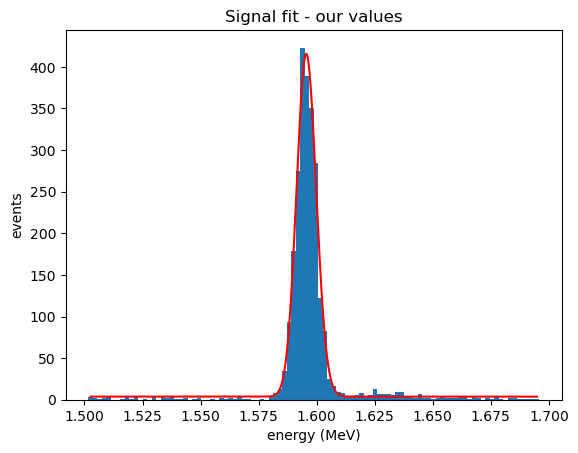

        Fitting output      
B1: 4.3608 ± 0.0458
A: 0.6979 ± 0.2761
mu: 1.5935 ± 0.0007
sigma: 0.0048 ± 0.0004


0

In [24]:
func.plot_fit(sig_func_fixed, centres, popt_f, fit_labels_fixed, popt_text=True)
func.plot_hist(sig_data, binning = 100, title='Signal fit - our values', log = False)
plt.show()
print_parameters(popt_f, pcov_f, fit_labels_fixed)

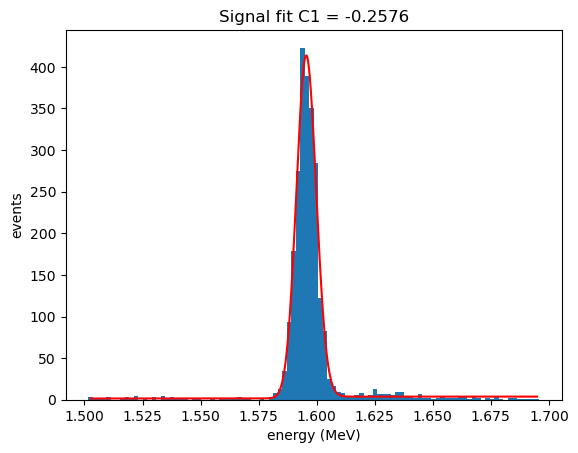

In [25]:
func.plot_fit(sig_func_fixed, centres, [4.3838, 0.6210, 1.5936, 0.0047, -0.2576, 0.8532], fit_labels_fixed, popt_text=True)
func.plot_hist(sig_data, binning = 100, title='Signal fit C1 = -0.2576', log = False)
plt.show()

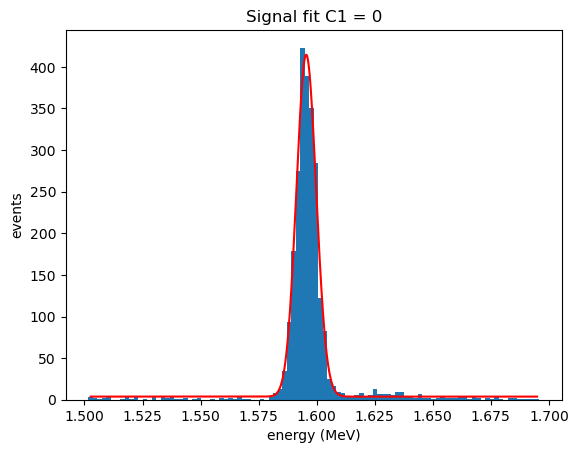

In [26]:
func.plot_fit(sig_func_fixed, centres, [4.3838, 0.6210, 1.5936, 0.0047, 0, 0.8532], fit_labels_fixed, popt_text=True)
func.plot_hist(sig_data, binning = 100, title='Signal fit C1 = 0', log = False)
plt.show()

### studying the port difference in this true energy distribution

In [46]:
port_1a_Es = sig_data.loc[sig_data['PORT'] == '1a']['energy'].to_numpy()
port_1b_Es = sig_data.loc[sig_data['PORT'] == '1b']['energy'].to_numpy()
port_2a_Es = sig_data.loc[sig_data['PORT'] == '2a']['energy'].to_numpy()

labels = ['1a', '1b', '2a']

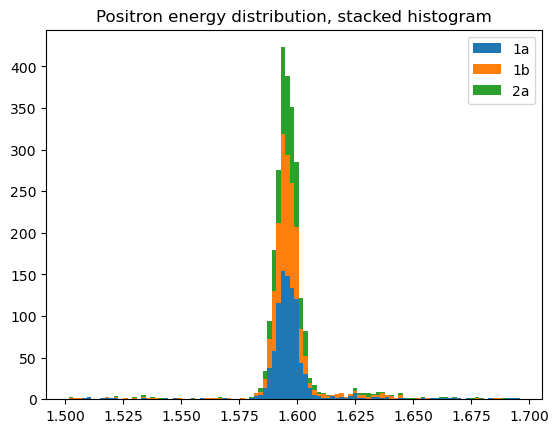

In [47]:
plt.hist([port_1a_Es, port_1b_Es, port_2a_Es], bins = 100, stacked = True, label=labels)
plt.legend()
plt.title('Positron energy distribution, stacked histogram')
plt.show()

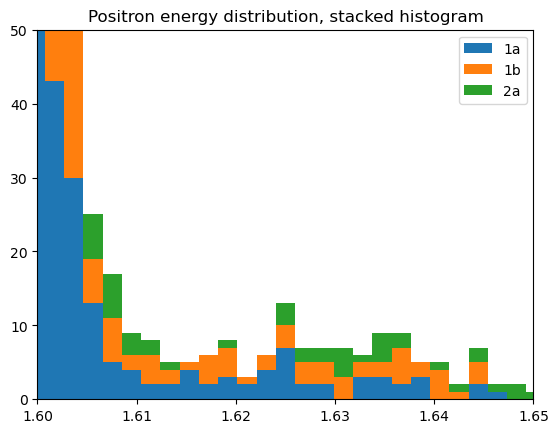

In [50]:
plt.hist([port_1a_Es, port_1b_Es, port_2a_Es], bins = 100, stacked = True, label=labels)
plt.xlim([1.60,1.650])
plt.ylim([0,50])
plt.legend()
plt.title('Positron energy distribution, stacked histogram')
plt.show()

the conclusion is the ports make little if any difference...

### So now back to fitting signal + background with fixed C1 and C2.
Lets do everything step by step here.

First, create MC fit from positron information and obtain C1 and C2 values

Second, Create FOM loop for fitting where:

    - Gaussian fit extracted from initial signal plus background
    - cut applied on eblob2, with parameters set by previously described fits
    - FOM calculated with this.

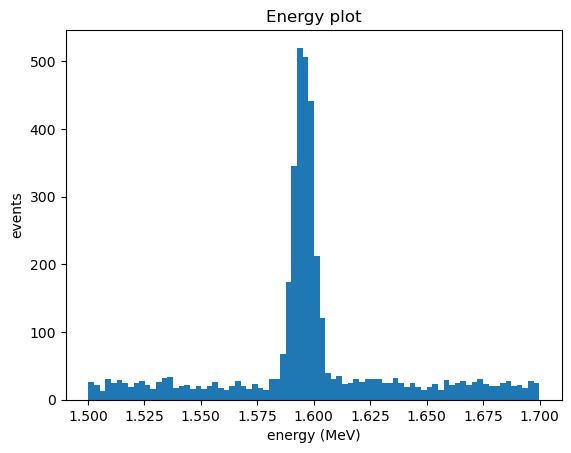

In [78]:
# show histogram of plot
cnts, edges, patches = func.plot_hist(cut_tracks[0], binning = 80, log = False, data = True)
centres = shift_to_bin_centers(edges)


In [59]:
# collect positron events (requires positron events and signal event separation)
sig_data = cut_tracks[0][cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]
bck_data = cut_tracks[0][~cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]

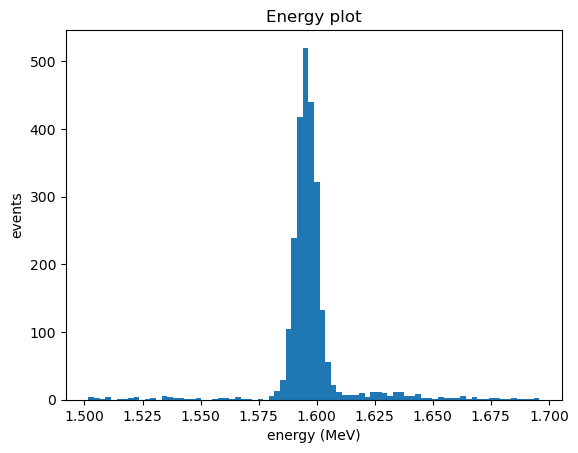

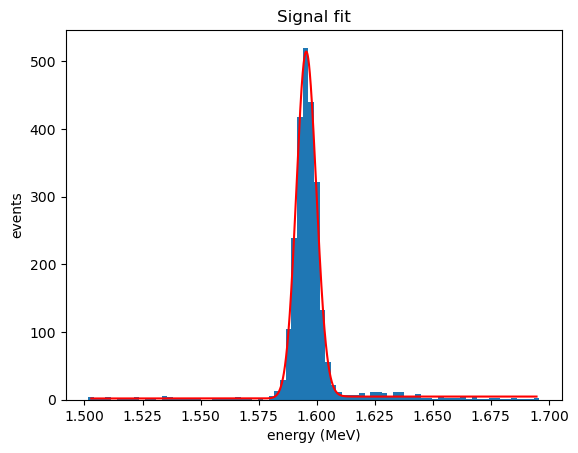

        Fitting output      
B1: 5.4798 ± 0.0374
A: 0.6554 ± 0.1841
mu: 1.5935 ± 0.0005
sigma: 0.0048 ± 0.0002
C1: -0.2568 ± 0.1032
C2: 0.8522 ± 0.1447


0

In [79]:
# fit signal events to the signal function
s_cnt, s_edges, s_patches = func.plot_hist(sig_data, binning = 80, log = False, data = True, output = True)
# p0 is apriori
p0 = ([1, 1, 1.58, 0.3, 0.8, 0])
fit_labels = ['B1', 'A', 'mu', 'sigma', 'C1', 'C2']

s_centres = shift_to_bin_centers(s_edges)

s_popt, s_pcov = curve_fit(func.sig_func, s_centres, s_cnt, p0, maxfev = 500000)

func.plot_fit(func.sig_func, s_centres, s_popt, fit_labels, popt_text=True)
func.plot_hist(sig_data, binning = 80, title='Signal fit', log = False)
plt.show()
print_parameters(s_popt, s_pcov, fit_labels)

In [80]:
# set base conditions here for controlling C1 and C2
C1 = popt[4]
C2 = popt[5]

# set to zero if negative
if (C1 < 0):
    C1 = 0
if (C2 < 0):
    C2 = 0
print("C1: {}, C2: {}".format(C1, C2))

C1: 0, C2: 0.8522059251196049


In [85]:
# collect gaussian fit from the peak of all the data
g_p0 = [500, 1.6, 0.01]
g_labels = ['A', 'mu', 'sigma']

g_popt, g_pcov = curve_fit(func.gauss, centres, cnts, g_p0, maxfev = 500000)

# collect the relevant parameters for the further fits
mew = g_popt[1]
sigmew = g_popt[2]

print("mu: {}, sigma: {}".format(mew, sigmew))

mu: 1.5955381928874994, sigma: 0.004575125262129542


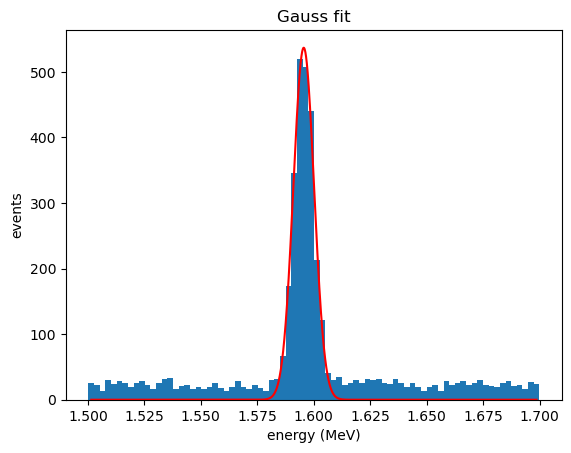

        Fitting output      
A: 536.7522 ± 15.9565
mu: 1.5955 ± 0.0002
sigma: 0.0046 ± 0.0002


0

In [83]:
# for visualising
func.plot_fit(func.gauss, centres, g_popt, g_labels, popt_text = True)
func.plot_hist(cut_tracks[0], binning = 80, title = 'Gauss fit', log = False)
plt.show()
print_parameters(g_popt, g_pcov, g_labels)

In [108]:
# collect number of events for restriction of ns and nb

# apply overall fit, with restricted C1, C2, mu and sigma
fixed_sig_bck_func = lambda x, ns, a, nb, tau: func.sig_bck_func(x, ns, a, mew, sigmew, C1, C2, nb, tau)
sb_p0 = [400, 1, 20, 0.1]
sb_labels = ['ns', 'a', 'nb', 'tau']
sb_popt, sb_pcov = curve_fit(fixed_sig_bck_func, centres, cnts, sb_p0, maxfev = 500000)

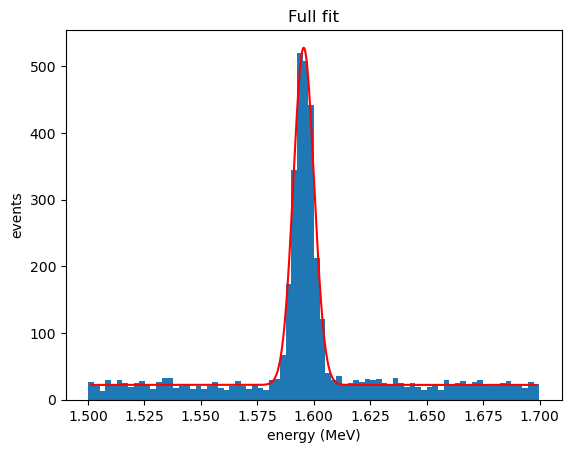

        Fitting output      
ns: 5.7956 ± 0.0602
a: -0.0000 ± 0.0177
nb: 17.2574 ± 1.0740
tau: 1131989.8267 ± 0.0000


0

In [109]:
# for visualising
func.plot_fit(fixed_sig_bck_func, centres, sb_popt, sb_labels, popt_text = True)
func.plot_hist(cut_tracks[0], binning = 80, title = 'Full fit', log = False)
plt.show()
print_parameters(sb_popt, sb_pcov, sb_labels)

In [104]:
# collect the number of signal and background events with integration
emin = 1.5
emax = 1.7
# take bin widths to calculate number of events
bin_width = centres[1] - centres[0]
ns = quad(func.sig_func, emin, emax, args = (sb_popt[0],sb_popt[1], mew, sigmew, C1, C2))/bin_width
nb = quad(func.bck_func, emin, emax, args = (sb_popt[2], sb_popt[3]))/bin_width
print(ns, nb)
print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(ns[0], nb[0],ns[0] + nb[0], len(cut_tracks[0].index)))

[2.71809855e+03 3.14702639e-05] [1.38300998e+03 1.53544953e-11]
Signal events: 2718.098547315979
Background events: 1383.0099841952003
Total Events by addition: 4101.1085315111795
Total Events by row counting: 4098
